# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
from IPython.core.display import display, HTML

def show(m):
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 609px;', 1)
    display(HTML(data_fixed_height))

In [3]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)
show(m)

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import random
drive.mount("/content/drive")

%matplotlib inline

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 14, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

np.random.seed(0)

Mounted at /content/drive


## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [5]:
!unzip /content/drive/MyDrive/ML2/train.zip

Archive:  /content/drive/MyDrive/ML2/train.zip
  inflating: train.csv               


In [6]:
train = pd.read_csv('train.csv')
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [7]:
train.drop(columns=['dropoff_datetime'], inplace=True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

<Axes: xlabel='trip_duration', ylabel='Count'>

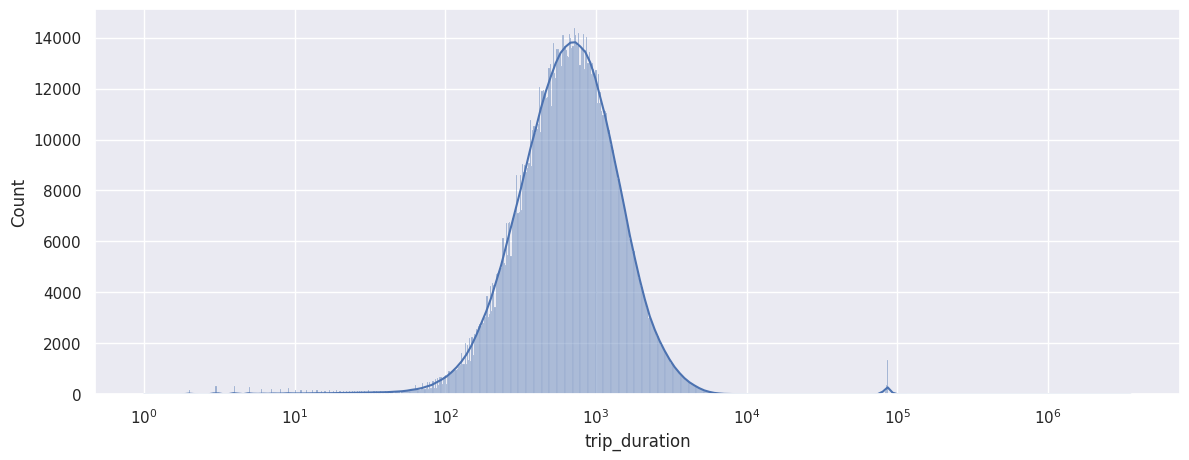

In [ ]:
sns.histplot(train['trip_duration'], log_scale=True, kde=True)

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Видим, что таргет принимает довольно большие значения(действительно, ведь он же в секундах). Также видим тут нечто похожее на нормальное распределение со среднем $\approx 10^3$

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Логарифм тут нужен только из-за большого значения и большого рэнджа таргета, типа мы не хотим считать очень большие ошибки, если они и в правду такими являются

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: $$ \text{RMSLE}(X, y, a)=\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}=\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2}=\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2}=\sqrt{\text{MSE}(X,\hat y,\hat a)}$$

Ну а минимизация RMSE эквивалентна минимизации MSE

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])

<Axes: xlabel='log_trip_duration', ylabel='Count'>

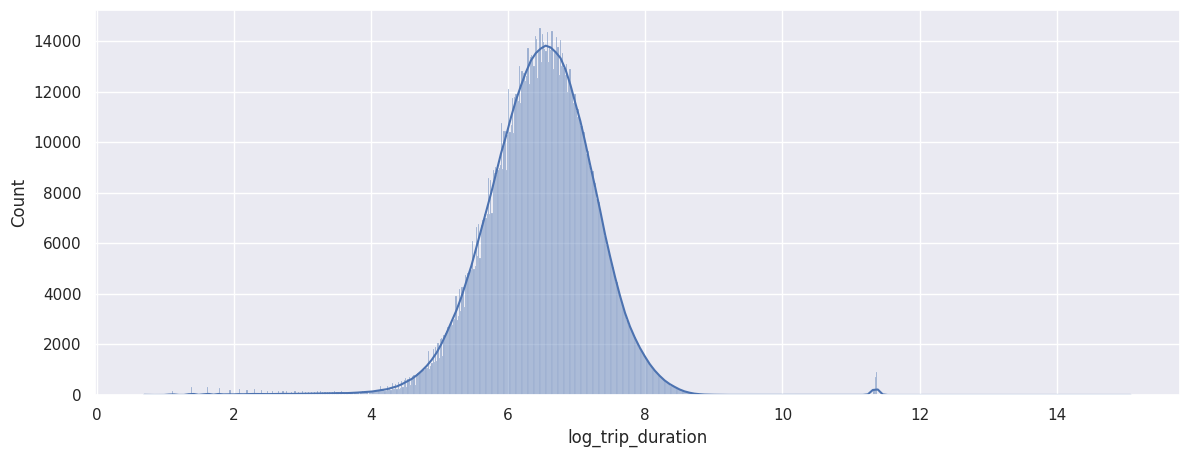

In [ ]:
sns.histplot(train['log_trip_duration'], kde=True)

In [9]:
train.drop(columns=['trip_duration'], inplace=True)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    error = (log1p_y_true - log1p_y_pred) ** 2
    return np.sqrt(np.mean(error))

rmsle_best_const = rmsle(train['log_trip_duration'], np.mean(train['log_trip_duration']))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

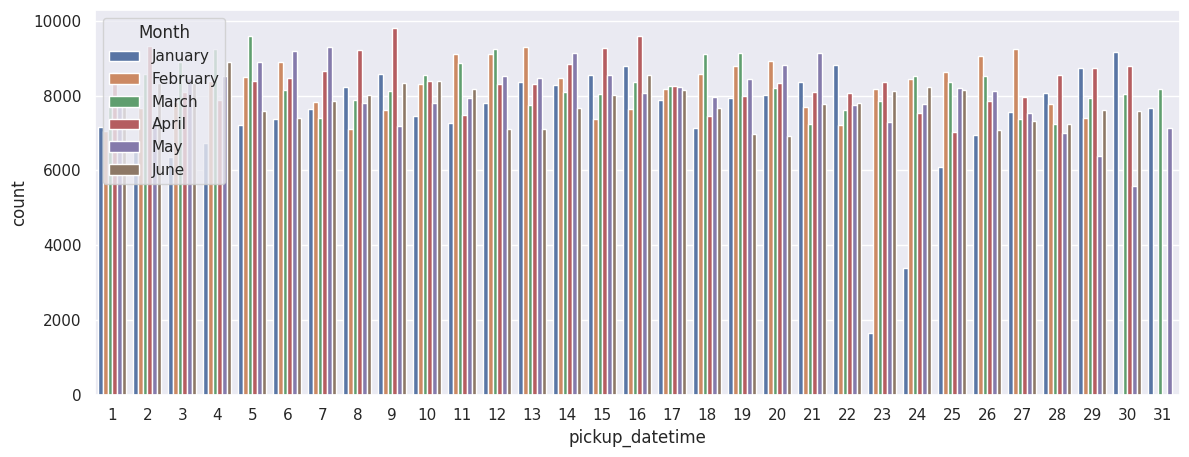

In [ ]:
g = sns.countplot(x=train['pickup_datetime'].dt.day, hue=train['pickup_datetime'].dt.month)
plt.legend(title='Month', loc='upper left', labels=['January', 'February', 'March', 'April', 'May', 'June'])

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.



Из графика видно, что аномалии происходили 23-25 января и 29-30 мая. Первое -- [ебейший снегопад](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard), второе -- судя по [прогнозу погоды](https://weatherspark.com/h/m/147190/2016/5/Historical-Weather-in-May-2016-at-New-York-City-Central-Park;-New-York;-United-States) в эти дни было чересчур жарковато(но вообще в images дофига фоток рианны от этого числа), ещё был memorial day(дороги перекрыты).

In [ ]:
train['pickup_datetime'].dt.date.value_counts().sort_values()[:10] #это если кодом

2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
2016-05-29    6372
2016-01-02    6512
2016-01-04    6725
2016-06-20    6910
2016-01-26    6941
Name: pickup_datetime, dtype: int64

Ну а про первую неделю января я думаю даже говорить не надо))))

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

[(10000.0, 100000.0)]

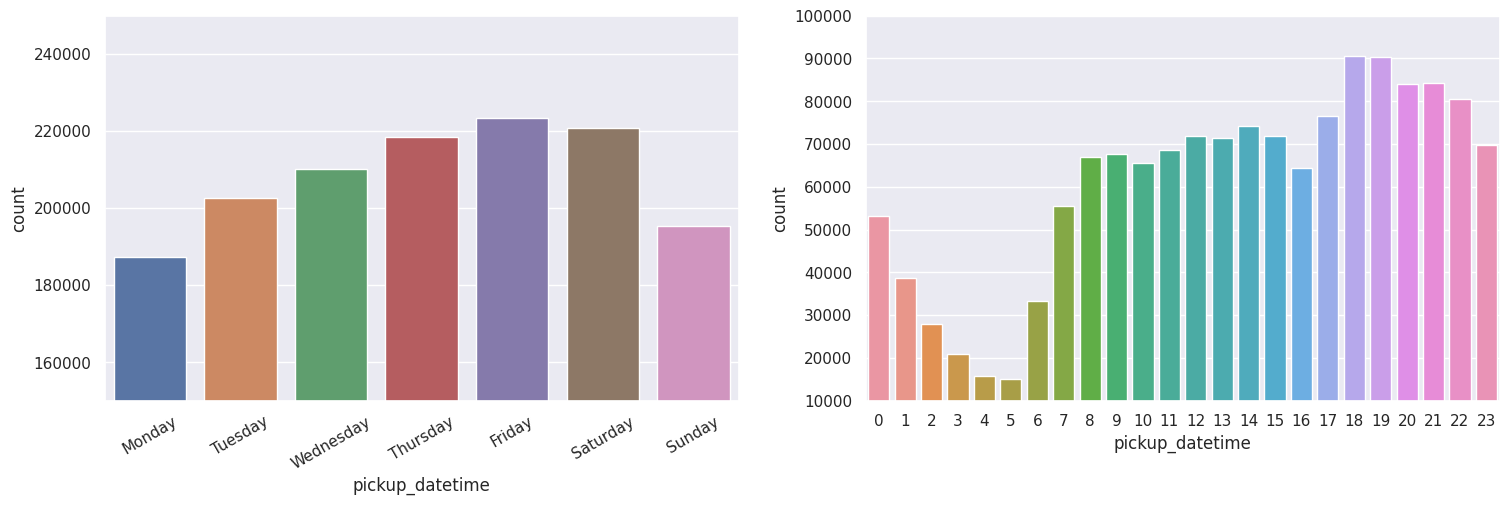

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.countplot(ax=axes[0], x=train['pickup_datetime'].dt.dayofweek)
axes[0].set(ylim=(150000,250000))
axes[0].set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=30)

g = sns.countplot(ax=axes[1], x=train['pickup_datetime'].dt.hour)
axes[1].set(ylim=(10000,100000))

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

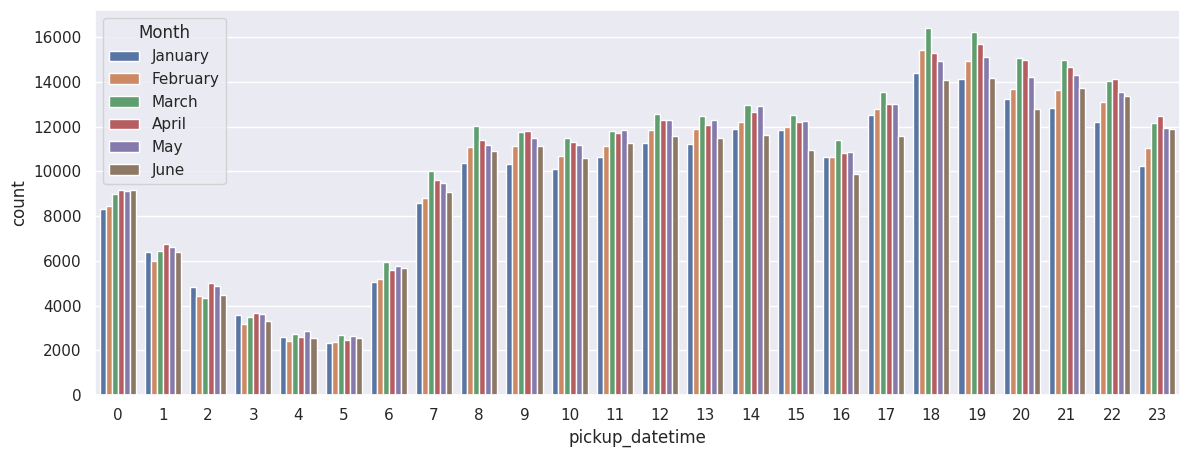

In [ ]:
g = sns.countplot(x=train['pickup_datetime'].dt.hour, hue=train['pickup_datetime'].dt.month)
plt.legend(title='Month', labels=['January', 'February', 'March', 'April', 'May', 'June'])

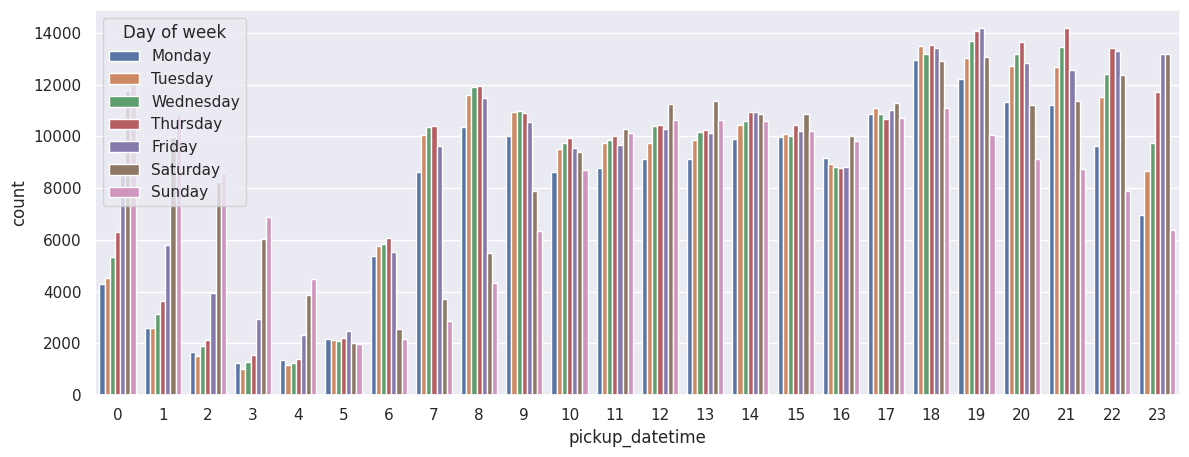

In [ ]:
g = sns.countplot(x=train['pickup_datetime'].dt.hour, hue=train['pickup_datetime'].dt.dayofweek)
plt.legend(title='Day of week', labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Ночами(2-6 часов) поездок не много всегда, ближе к утру они увеличиваются(люди едут на работу), потом всё равномерно, и ближе к вечеру, особенно пятница-воскресенье количество поездок увеличивается(все едут на лютый бухич), ну и всё по новой; на выходных поездок в раннее время почти нет(кто блять вообще ходит на работу в выходные); к тому же в воскресенье мало поездок к концу вечера, так как перед понедельником бухать -- это грех.

Ещё как будто чем теплее становится, тем меньше поездок совершают ребята с Нью-Йорка

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [10]:
from sklearn.model_selection import train_test_split

# y = data_from_train['log_trip_duration']
# data_from_train.drop(columns=['log_trip_duration'], inplace=True)

X_train, X_test = train_test_split(train, test_size=0.3, random_state=10)

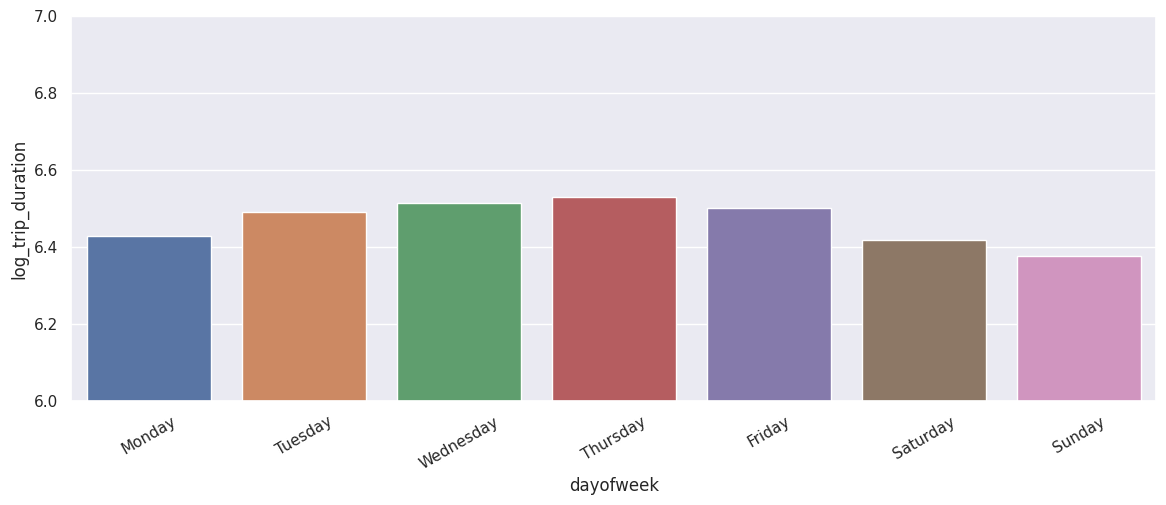

In [ ]:
X_train['dayofweek'] = X_train['pickup_datetime'].dt.dayofweek
tmp = X_train.groupby(by='dayofweek')['log_trip_duration'].mean().reset_index()
g=sns.barplot(x=tmp['dayofweek'], y=tmp['log_trip_duration'])
g.set(ylim=(6,7))
g.set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=30)
plt.show(g)

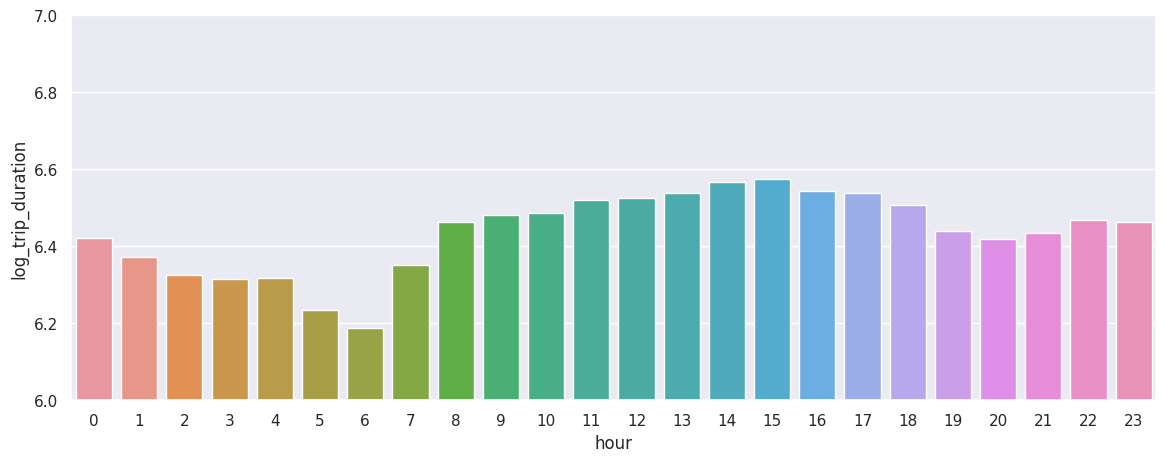

In [ ]:
X_train['hour'] = X_train['pickup_datetime'].dt.hour
tmp = X_train.groupby(by='hour')['log_trip_duration'].mean().reset_index()
g=sns.barplot(x=tmp['hour'], y=tmp['log_trip_duration'])
g.set(ylim=(6,7))
plt.show(g)

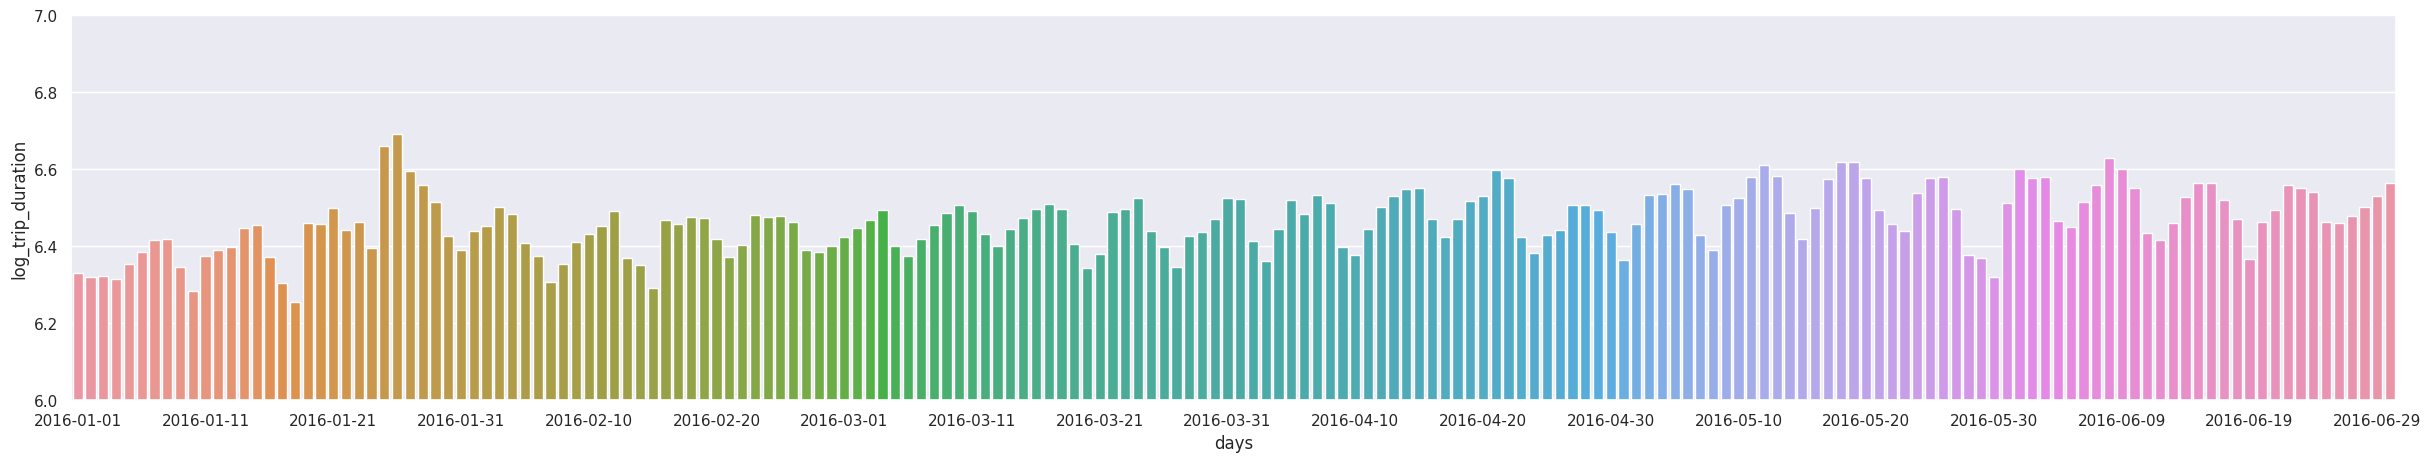

In [ ]:
X_train['date'] = X_train['pickup_datetime'].dt.date
fig, ax = plt.subplots(figsize=(30, 5))
tmp = X_train.groupby(by='date')['log_trip_duration'].mean().reset_index()
g=sns.barplot(x=tmp['date'], y=tmp['log_trip_duration'])
g.set_xticks(g.get_xticks()[::10])
g.set(ylim=(6,7),xlabel='days')
plt.show(g)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

* Графики зависимости таргета от дня недели и от часа в сутках похожи на
аналогичные графики для количества поездок. Как мне кажется, это просходит потому что при увеличении спроса на поездки возрастает и время.

* 23-25 января наблюдается особенно большая длительность поездок, потому что шёл снегопад.

* 29-30 мая люди скорее всего предпочли остаться дома или не ездить на дальние расстояния, поэтому и длительность была небольшая.

* От дня в году тренда не вижу, разве что циклические подъёмы и спады в пятницу и воскресенье/понедельник.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [11]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['month'] = train['pickup_datetime'].dt.month
train['hour'] = train['pickup_datetime'].dt.hour
train['dayofyear'] = train['pickup_datetime'].dt.dayofyear
train['is_blizzard'] = (23<=train['dayofyear']) & (train['dayofyear']<=25)
train['is_heat'] = (150<=train['dayofyear'])&(train['dayofyear']<=151)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Имхо, их всех стоит сделать категориальными, потому что увеличение номера дня или часа на 1 не должно увеличить значение таргета. Так же все признаки имеют фиксированное количество значений(дней 183, дней недели 7 и тд...).

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [12]:
numeric_features = []
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_blizzard', 'is_heat']

In [13]:
y = train['log_trip_duration']

# train.drop(columns=['log_trip_duration','id'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=10)

In [14]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model1 = pipeline.fit(X_train, y_train)
y_pred = model1.predict(X_test)
y_train_pred = model1.predict(X_train)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
# print("Train RMSlE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.7865


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return show(m)

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

На самом деле таких пунктов не так уж и много:

* Вокзалы/аэропорты (особенно хочется отнести penn station)
* Достопримечательности (madison square garden, times square, empire state building)
* Паромные переправы(не хотелось бы их относить к первому пункту, потому что это немного другое)

Да и в целом почти все поездки приходятся на downtown и midtown манхэттана.

Особенности этих точек вроде ясны, но всё же: из аэропортов (формально их 3, но почти всё обслуживается аэропортом дж.кеннеди) достаточно долго ехать до манхэттана; длину поездки с вокзала сложно оценить, но это одни из самых загруженных вокзалов мира, поэтому заказов там точно много; достопримечательности -- очев; паромные переправы мне просто показались интересными, типа это прикольный способ попасть из одного боро в другой с безумно красивым видом на весь downtown.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [15]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train.loc[:, 'haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [16]:
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
your_df = train
assert your_df['log_haversine'].corr(y) > your_df['haversine'].corr(y)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=10)

<Axes: ylabel='Count'>

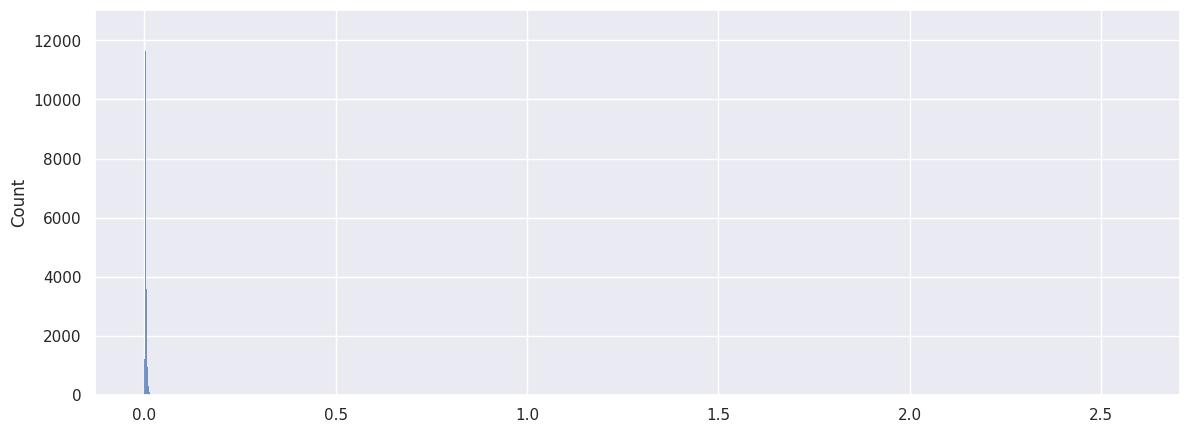

In [ ]:
sns.histplot(X_train['haversine']/np.expm1(y_train))

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [18]:
X_train['speed'] = X_train['haversine']/np.expm1(y_train)
normal_speed = np.quantile(X_train['speed'], 0.9)

<Axes: xlabel='speed', ylabel='Count'>

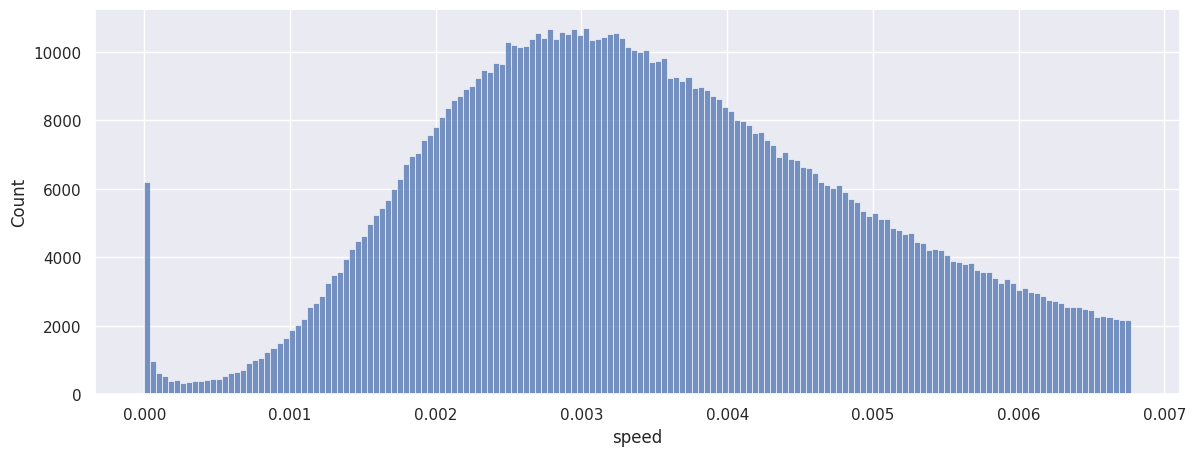

In [ ]:
sns.histplot(X_train[X_train['speed'] < normal_speed]['speed'])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<Axes: xlabel='hour', ylabel='dayofweek'>

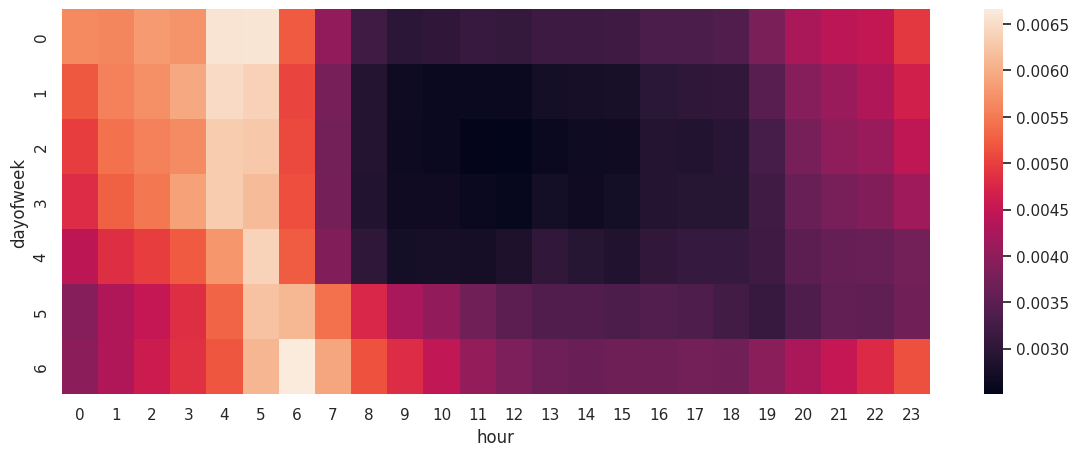

In [ ]:
tmp = X_train.groupby(by=['dayofweek','hour'])['speed'].median().reset_index()
sns.heatmap(tmp.pivot(index="dayofweek", columns="hour", values="speed"))

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Имея скорость, мы можем вычислить время, а его мы хотим предсказывать:)


In [19]:
X_train.drop(columns=['speed'], inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

* Скорость максимальна, когда на дорогах нет пробок, то есть ночью 3-5 утра(в выходные это время смещается вправо на 1, что вполне логично)

* Скорость минимальна в рабочие дни в 11-12 -- часы пик(на дорогах там наверное полнейшая жопа)

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [20]:
jam = (((train['dayofweek']>=0) & (train['dayofweek']<=4)) & ((train['hour']>=8) & (train['hour']<=18))) | (((train['dayofweek']>=5) & (train['dayofweek']<=6)) & ((train['hour']>=13) & (train['hour']<=18)))
free = (((train['dayofweek']>=0) & (train['dayofweek']<=4)) & ((train['hour']>=4) & (train['hour']<=5))) | (((train['dayofweek']>=5) & (train['dayofweek']<=6)) & ((train['hour']>=5) & (train['hour']<=6)))
train['is_jam'] = 0
train.loc[jam, 'is_jam'] = 1
train['is_free'] = 0
train.loc[free, 'is_free'] = 1

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

Благодаря таким признакам мы будем видеть, что в условный аэропорт в какое-то время едет большое количество народа, соответственно время в дороге будет выше. Для достопримечательностей и паромов это, кажется, не так важно и не будет давать буста к предсказанию, потому что расположены они в центре города и туда и многие предпочтут добраться туда на метро. Но ещё у нас есть два вокзала, и с ними логика "есть метро -- поеду на нём" уже не работает. Поэтому этот признак я тоже вынесу отдельно.

In [21]:
LGA = (40.777130183562086, -73.87394444590299)
JFK = (40.64674152546153, -73.77949345715341)
PenSt = (40.750253722656694, -73.99309171053883)
GCT = (40.75293081424571, -73.97713337394121)

def check_coord(type, place, radius=0.3):
    return haversine_array(train[f'{type}_latitude'], train[f'{type}_longitude'], place[0], place[1]) <= radius

train['pickup_lga'] = 0
train['dropoff_lga'] = 0
train['pickup_jfk'] = 0
train['dropoff_jfk'] = 0
train['pickup_penst'] = 0
train['dropoff_penst'] = 0
train['pickup_gct'] = 0
train['dropoff_gct'] = 0
train.loc[check_coord('pickup', LGA, 1.5), 'pickup_lga'] = 1
train.loc[check_coord('dropoff', LGA, 1.5), 'dropoff_lga'] = 1
train.loc[check_coord('pickup', JFK, 5), 'pickup_jfk'] = 1
train.loc[check_coord('dropoff', JFK, 5), 'dropoff_jfk'] = 1
train.loc[check_coord('pickup', PenSt), 'pickup_penst'] = 1
train.loc[check_coord('dropoff', PenSt), 'dropoff_penst'] = 1
train.loc[check_coord('pickup', GCT), 'pickup_gct'] = 1
train.loc[check_coord('dropoff', GCT), 'dropoff_gct'] = 1


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

<Axes: xlabel='dropoff_gct', ylabel='log_trip_duration'>

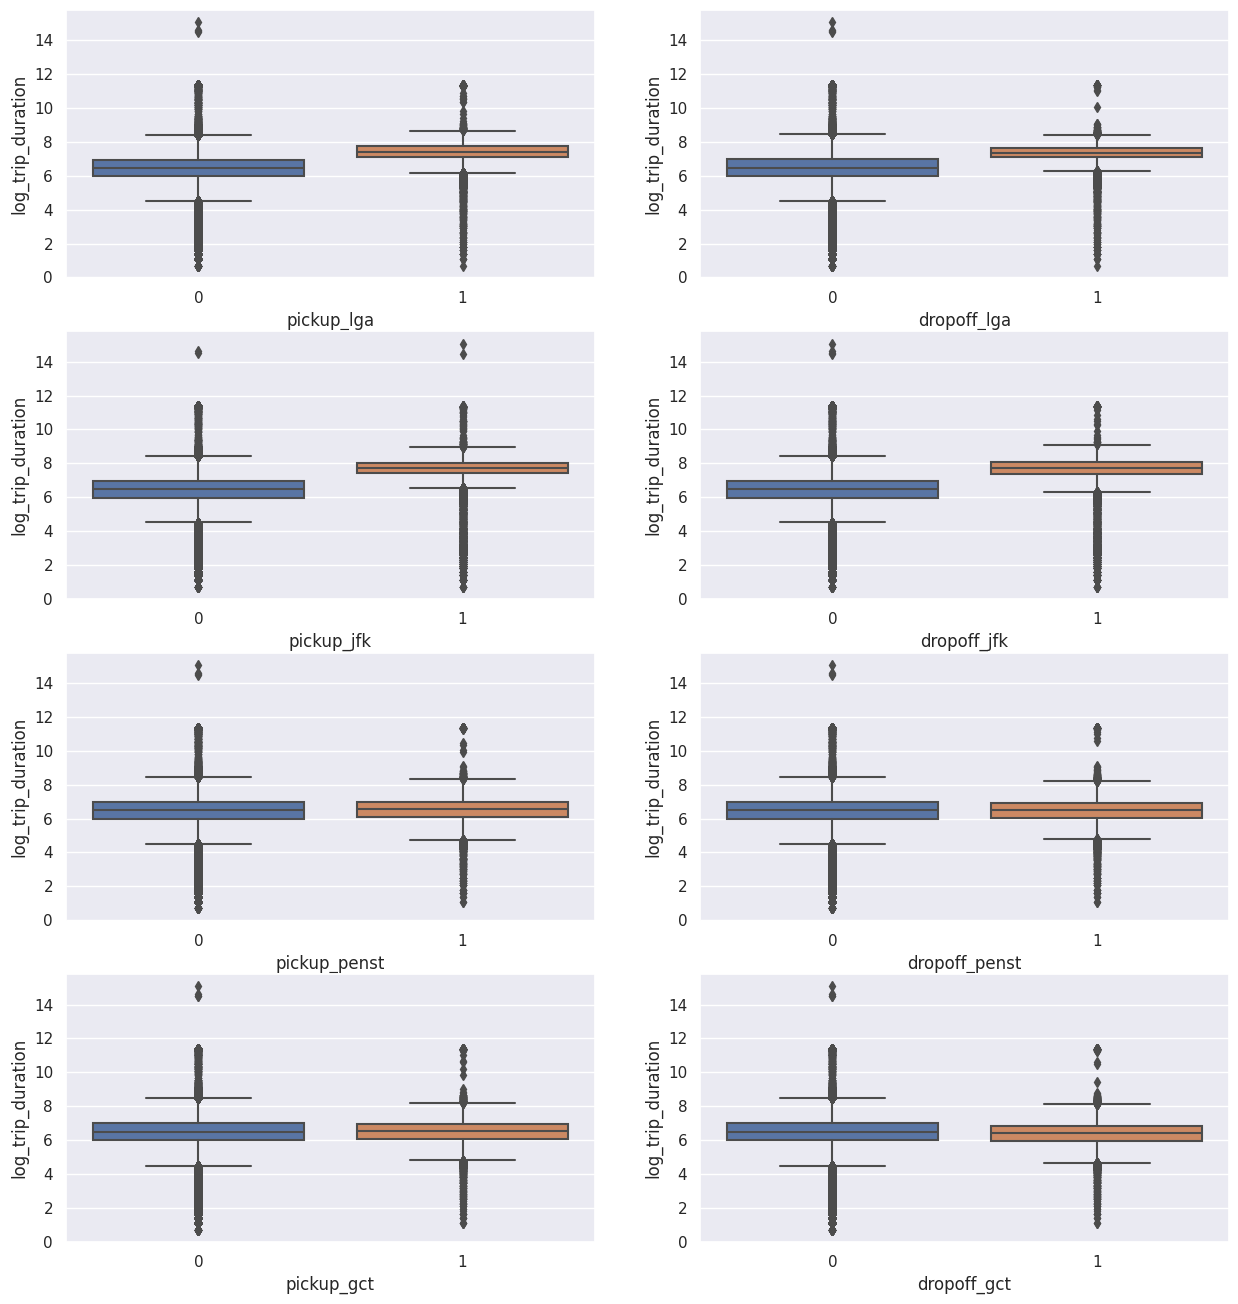

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
sns.boxplot(ax=axes[0, 0], x=train['pickup_lga'], y=y)
sns.boxplot(ax=axes[0, 1], x=train['dropoff_lga'], y=y)
sns.boxplot(ax=axes[1, 0], x=train['pickup_jfk'], y=y)
sns.boxplot(ax=axes[1, 1], x=train['dropoff_jfk'], y=y)
sns.boxplot(ax=axes[2, 0], x=train['pickup_penst'], y=y)
sns.boxplot(ax=axes[2, 1], x=train['dropoff_penst'], y=y)
sns.boxplot(ax=axes[3, 0], x=train['pickup_gct'], y=y)
sns.boxplot(ax=axes[3, 1], x=train['dropoff_gct'], y=y)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: у аэропортов разборс небольшой, а значит мы можем точнее предсказать длительность поезки; в то же время с вокзалами я походу проебался, потому что их графики ничем не отличаются от графиков движения по городу в целом.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

Перед тем, как писать ёбаный трансформер, разабъём нью-йорк на ячейки. Возьмём верхнюю левую и правую нижнуюю точки(скопируем с карт координаты) и по ним построим прямоугольник. Не будем ничего мудрить и оставим такое же количесто столбцов и строк.

In [22]:
left_up = (40.799099019374246, -74.02022901925183)
# right_down = (40.70720903557412, -73.9383877317797)
right_down = (40.70286377270773, -73.93831027410894)

location = (train['pickup_latitude'].mean(), train['pickup_longitude'].mean())
m = folium.Map(location=location, zoom_start=12)

folium.Rectangle([left_up, right_down],
                 color='red',
                 fill=False, fill_opacity=0.5
                 ).add_to(m)

show(m)

Вроде похоже.

Теперь разбиваем на ячейки

In [23]:
cell_coords = []
cell_h = (right_down[0] - left_up[0])/4     #<0
cell_w = (right_down[1] - left_up[1])/3     #>0
for i in range(4):
    for j in range(3):
        cell_left_up = (left_up[0] + cell_h * i, left_up[1] + cell_w * j)
        cell_right_down = (left_up[0] + cell_h * (i + 1), left_up[1] + cell_w * (j + 1))
        cell_coords.append((cell_left_up, cell_right_down))

In [24]:
def is_rectangle(df, type, left_up, right_down):
    return ((df[f'{type}_latitude']<=left_up[0]) & (df[f'{type}_latitude']>=right_down[0]) & (df[f'{type}_longitude']>=left_up[1]) & (df[f'{type}_longitude']<=right_down[1]))

location = (train['pickup_latitude'].mean(), train['pickup_longitude'].mean())
m = folium.Map(location=location, zoom_start=12)
data = X_train[is_rectangle(X_train, 'pickup', left_up, right_down)].sample(1000)
for _, row in data.iterrows():
    folium.Circle(
        radius=100,
        location=(row['pickup_latitude'], row['pickup_longitude']),
        color='blue',
        fill_color='blue',
        fill=True
        ).add_to(m)

folium.Rectangle([left_up, right_down],
                 color='red',
                 fill=False, fill_opacity=0.5
                 ).add_to(m)

show(m)

Получили, что хотели :)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
import random


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, fir_point=(40.799099019374246, -74.02022901925183), sec_point=(40.70286377270773, -73.93831027410894), num_rows=4, num_cols=3):
        cell_coords = []
        cell_h = (sec_point[0] - fir_point[0])/num_rows     #<0
        cell_w = (sec_point[1] - fir_point[1])/num_cols     #>0
        for i in range(num_rows):
            for j in range(num_cols):
                cell_left_up = (left_up[0] + cell_h * i, left_up[1] + cell_w * j)
                cell_right_down = (left_up[0] + cell_h * (i + 1), left_up[1] + cell_w * (j + 1))
                cell_coords.append((cell_left_up, cell_right_down))
        self.coords = cell_coords
        self.cell_num = num_rows * num_cols

    def __is_rectangle(self, df, type, coords):
        return ((df[f'{type}_latitude']<coords[0][0]) & (df[f'{type}_latitude']>coords[1][0]) & (df[f'{type}_longitude']>coords[0][1]) & (df[f'{type}_longitude']<coords[1][1]))


    def show_map(self, X, color_for_cell=None):
        # https://python-visualization.github.io/folium/latest/reference.html#:~:text=Leaflet.awesome%2Dmarkers.-,Parameters,-%3A
        # все цвета, которые воспринимаются буквами
        color_for_cell = ['beige', 'green', 'purple', 'orange','cadetblue', 'darkred','red','white','lightred','black','gray','#F9FF33']
        if self.cell_num > 12:
             color_for_cell = color_for_cell + ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(self.cell_num - 12)]) for i in range(self.cell_num)]
        else:
            color_for_cell = color_for_cell[:self.cell_num]
        color_for_cell = color_for_cell + ['blue']
        location = (X['pickup_latitude'].mean(), X['pickup_longitude'].mean())
        m = folium.Map(location=location, zoom_start=12)
        for rec in self.coords:
            folium.Rectangle([rec[0], rec[1]],
                 color='red',
                 fill=False, fill_opacity=0.5
                 ).add_to(m)
        for _, row in X.iterrows():
            folium.Circle(
                radius=100,
                location=(row['pickup_latitude'], row['pickup_longitude']),
                color=color_for_cell[row['pickup_at_cell']],
                fill_color=color_for_cell[row['pickup_at_cell']],
                fill=True
                ).add_to(m)
        for _, row in X.iterrows():
            folium.Circle(
                radius=100,
                location=(row['dropoff_latitude'], row['dropoff_longitude']),
                color=color_for_cell[row['dropoff_at_cell']],
                fill_color=color_for_cell[row['dropoff_at_cell']],
                fill=True
                ).add_to(m)
        return show(m)


    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
        X1 = X.copy()   # чтобы не было inplace замены выборки
        X1['pickup_at_cell'] = -1
        X1['dropoff_at_cell'] = -1
        for cell_num, coords in enumerate(self.coords):
            X1.loc[self.__is_rectangle(X1, 'pickup', coords), 'pickup_at_cell'] = cell_num
            X1.loc[self.__is_rectangle(X1, 'dropoff', coords), 'dropoff_at_cell'] = cell_num
        return X1

In [26]:
trans = MapGridTransformer()
train_trans = trans.transform(train)
trans.show_map(train_trans.sample(1000))

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
train_trans.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'dayofweek', 'month', 'hour', 'dayofyear', 'is_blizzard', 'is_heat',
       'haversine', 'log_haversine', 'is_jam', 'is_free', 'pickup_lga',
       'dropoff_lga', 'pickup_jfk', 'dropoff_jfk', 'pickup_penst',
       'dropoff_penst', 'pickup_gct', 'dropoff_gct', 'pickup_at_cell',
       'dropoff_at_cell'],
      dtype='object')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_trans, y, test_size=0.3, random_state=10)

In [28]:
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_blizzard', 'is_heat', 'is_jam', 'is_free', 'pickup_lga', 'dropoff_lga','pickup_jfk', 'dropoff_jfk', 'pickup_penst', 'dropoff_penst','pickup_gct','dropoff_gct', 'pickup_at_cell', 'dropoff_at_cell']
numeric_features = ['log_haversine']


In [29]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model2 = pipeline.fit(X_train, y_train)
y_pred = model2.predict(X_test)
# y_train_pred = model1.predict(X_train)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
# print("Train RMSlE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.4710


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**:
* `vendor_id` указывает на компанию, которой принадлежит такси. Полезен он может быть в двух случаях: у одной компании в арсенале только минивены, у другой седаны, соответственно это могут быть совершенно разные виды поездок по времени и количеству пассажиров; возможно второй случай немного надуманный, но всё же: возможно компания _x_ говно, а компания _y_ нормальные парни(и девушки, конечно), тога с большей вероятностью люди выберут компанию _y_.
* `passenger_count` показывает количество пассажиров в такси. Его прикол в том, что у одной поездки(а мы помним, что в таблице все id-шники были уникальными) может быть не одна точка высадки(развоз людей после бухича с пятницы на субботу).
* `store_and_fwd_flag` может быть полезно в ситуацих, когда не очень надо полагаться на вермя поездки: поездка могла быть совершенна в 5-6 утра, а отправлена на сервер лишь в 9(понятно, что сначала пробок не было, а в 9 утра уже пиздец).

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
train_trans['vendor_id'].nunique()

2

In [ ]:
train_trans['passenger_count'].nunique()

10

In [ ]:
train_trans['store_and_fwd_flag'].nunique()

2

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<Axes: xlabel='vendor_id', ylabel='log_trip_duration'>

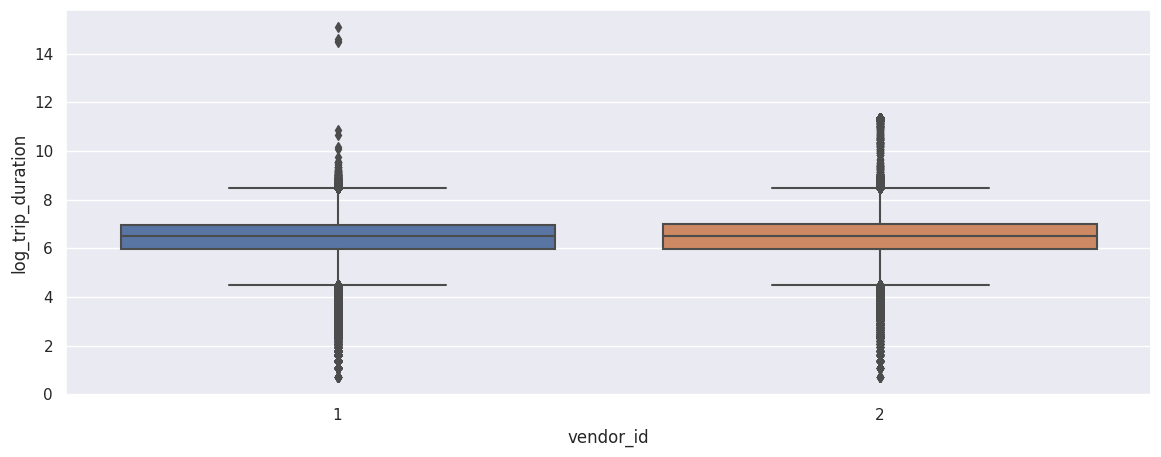

In [ ]:
sns.boxplot(x=train_trans['vendor_id'], y=y)

<Axes: xlabel='passenger_count', ylabel='log_trip_duration'>

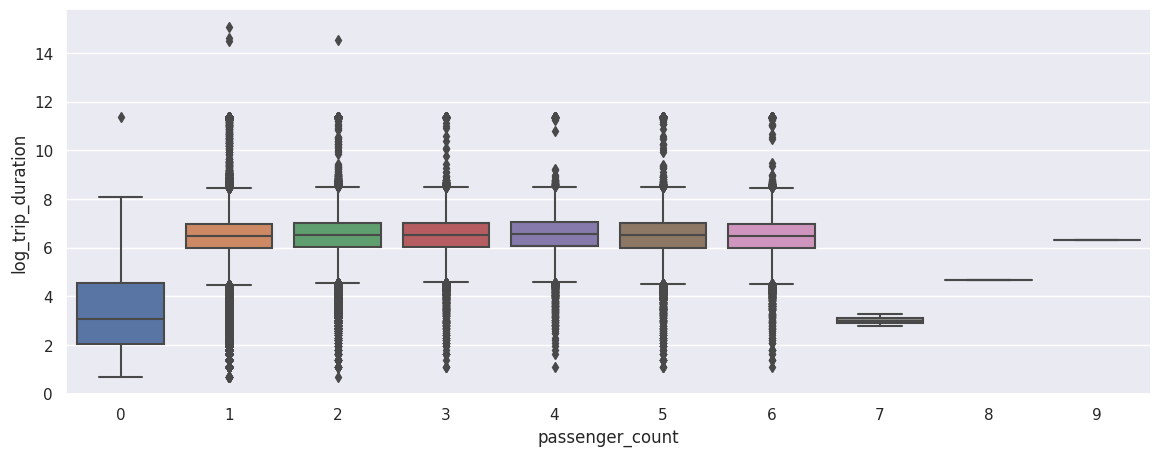

In [ ]:
sns.boxplot(x=train_trans['passenger_count'], y=y)

<Axes: xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

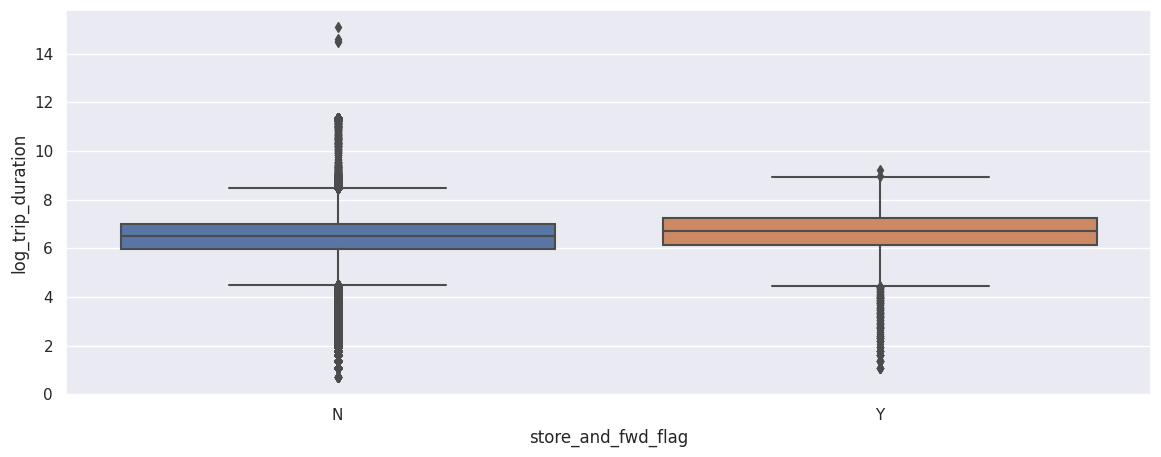

In [ ]:
sns.boxplot(x=train_trans['store_and_fwd_flag'], y=y)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [30]:
train_trans['store_and_fwd_flag'].replace({'N':0, 'Y':1}, inplace=True)
train_trans['vendor_id'].replace({1:0, 2:1}, inplace=True)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Из графика видно, что `vendor_id` вообще никак не влияет на время поездки; `passenger_count` как будто тоже не очень отличается от количества пассажиров; насчёт `store_and_fwd_flag` хз, видно, что при Y логарифм времени поездки выше, но что-то очень на немного.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_trans, y, test_size=0.3, random_state=10)

In [32]:
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_blizzard', 'is_heat', 'is_jam', 'is_free', 'pickup_lga', 'dropoff_lga','pickup_jfk', 'dropoff_jfk', 'pickup_penst', 'dropoff_penst','pickup_gct','dropoff_gct', 'pickup_at_cell', 'dropoff_at_cell']
numeric_features = ['log_haversine']

In [33]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model3 = pipeline.fit(X_train, y_train)
y_pred = model3.predict(X_test)
# y_train_pred = model1.predict(X_train)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
# print("Train RMSlE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.4710


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Ну мы улучшили модель на 0.0003, но как будто это херня какая-то

In [34]:
train_trans.drop(columns=['vendor_id','store_and_fwd_flag','passenger_count'], inplace=True)

In [35]:
X_train.drop(columns=['vendor_id','store_and_fwd_flag','passenger_count'], inplace=True)
X_test.drop(columns=['vendor_id','store_and_fwd_flag','passenger_count'], inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

<Axes: xlabel='log_trip_duration'>

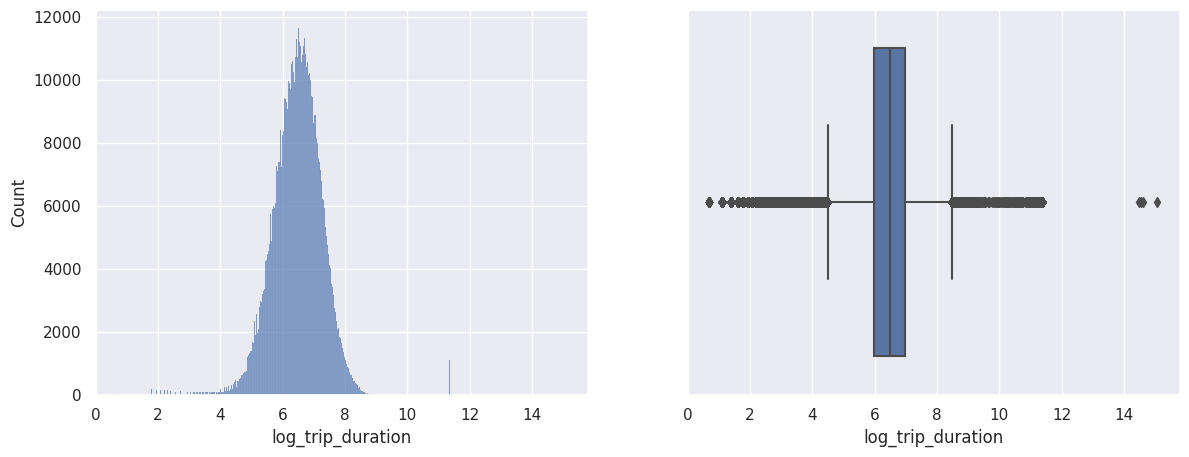

In [ ]:
fig, axes = plt.subplots(1,2)
sns.histplot(y_train,ax=axes[0])
sns.boxplot(x=y_train,ax=axes[1])

<Axes: xlabel='log_haversine'>

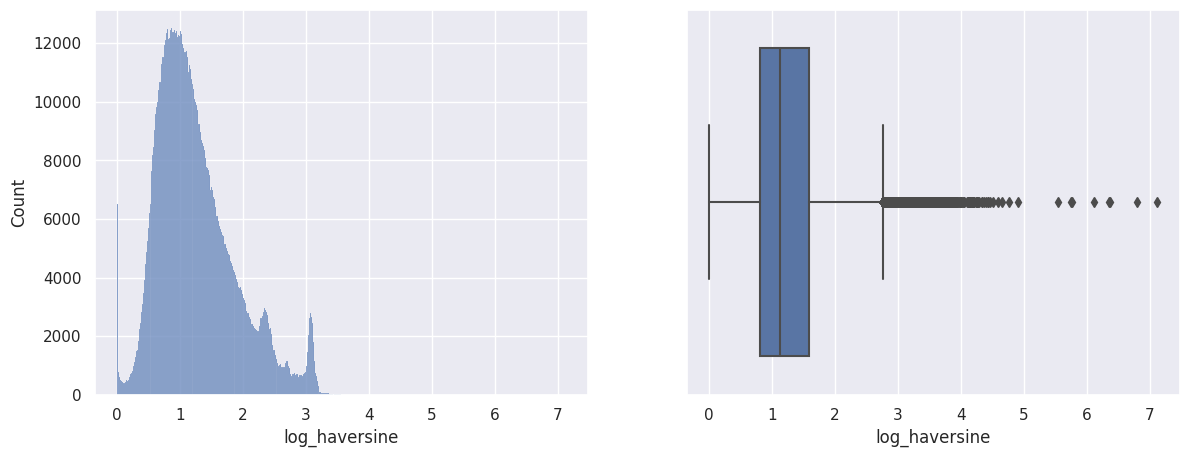

In [ ]:
fig, axes = plt.subplots(1,2)
sns.histplot(X_train['log_haversine'],ax=axes[0])
sns.boxplot(x=X_train['log_haversine'],ax=axes[1])

In [36]:
X_train['residual_of_regression'] = model2.predict(X_train) - y_train

<Axes: xlabel='residual_of_regression'>

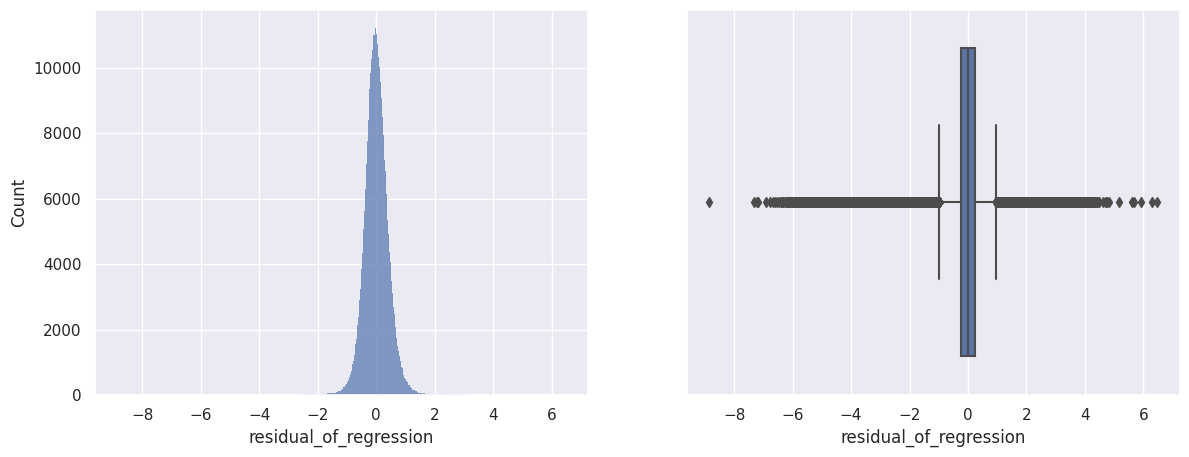

In [ ]:
fig, axes = plt.subplots(1,2)
sns.histplot(X_train['residual_of_regression'],ax=axes[0])
sns.boxplot(x=X_train['residual_of_regression'],ax=axes[1])

Имхо, гистограмма вообще неинформативна тут, а вот усы тащат.

* В `log_trip_duration` убираем всё, что больше 8.5 и меньше 4.5
* В `log_haversine` убираем всё, что больше 2.8
* В `residual_of_regression` убираем всё, что больше больше 1 и меньше -1

In [37]:
# X_train = pd.concat([X_train, y_train], axis=1)
#построил графики и решил, что значения надо немного увеличить, чтобы выбросов не было
X_train = X_train[(X_train['log_trip_duration']<=8.3) & (X_train['log_trip_duration']>=4.6)]
X_train = X_train[X_train['log_haversine']<=2.6]
X_train = X_train[(X_train['residual_of_regression']<=0.9) & (X_train['residual_of_regression']>=-0.9)]

<Axes: xlabel='log_trip_duration'>

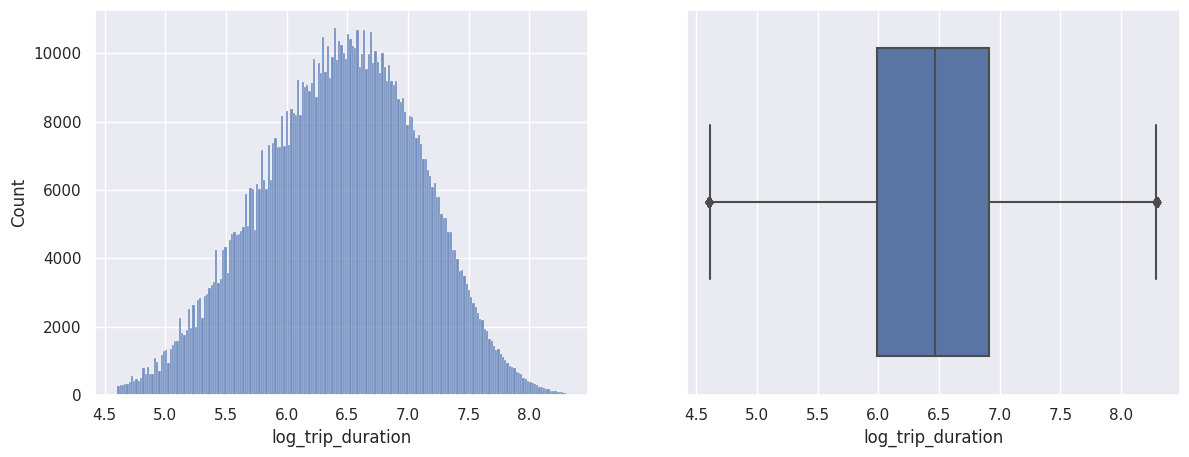

In [ ]:
fig, axes = plt.subplots(1,2)
sns.histplot(X_train['log_trip_duration'],ax=axes[0])
sns.boxplot(x=X_train['log_trip_duration'],ax=axes[1])

<Axes: xlabel='log_haversine'>

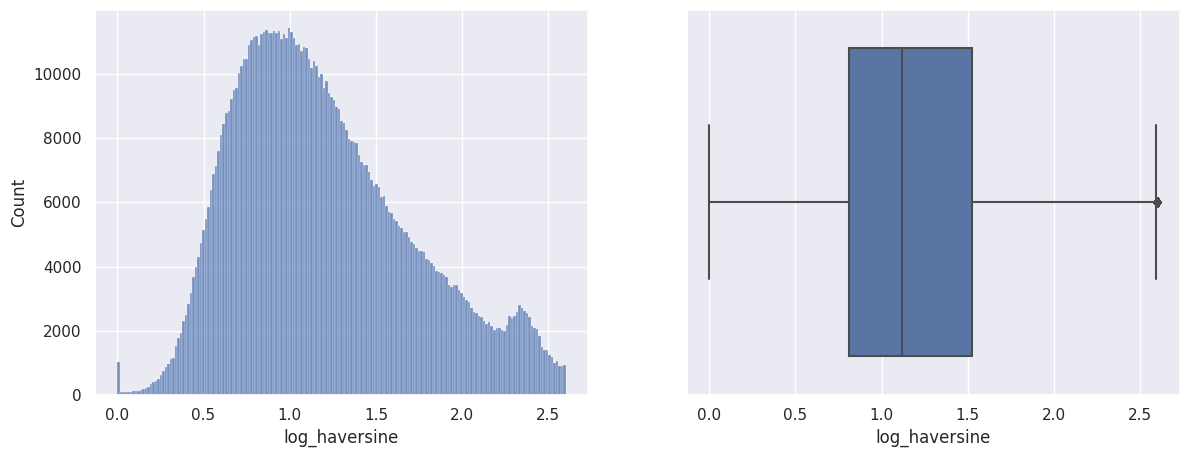

In [ ]:
fig, axes = plt.subplots(1,2)
sns.histplot(X_train['log_haversine'],ax=axes[0])
sns.boxplot(x=X_train['log_haversine'],ax=axes[1])

<Axes: xlabel='residual_of_regression'>

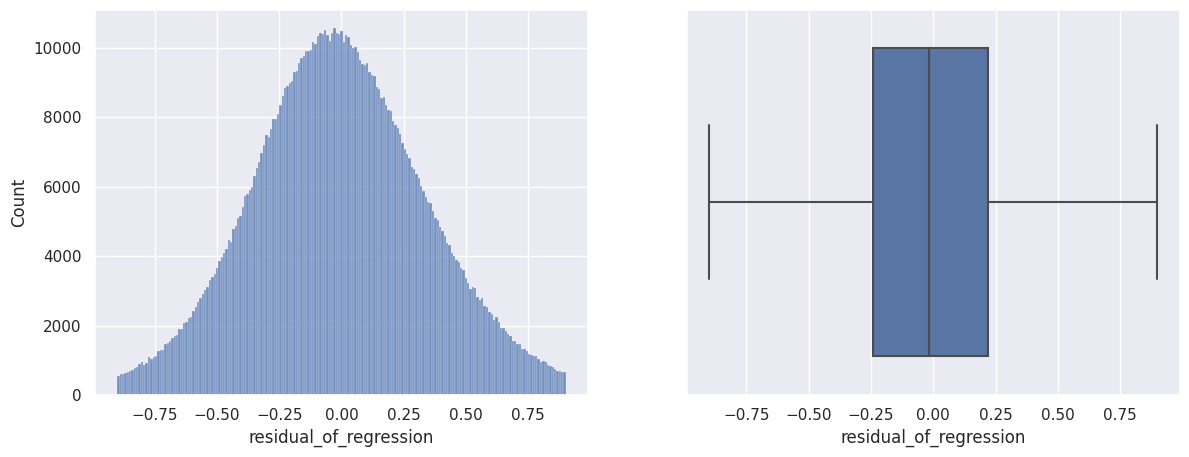

In [ ]:
fig, axes = plt.subplots(1,2)
sns.histplot(X_train['residual_of_regression'],ax=axes[0])
sns.boxplot(x=X_train['residual_of_regression'],ax=axes[1])

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
X_train.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'dayofweek', 'month', 'hour',
       'dayofyear', 'is_blizzard', 'is_heat', 'haversine', 'log_haversine',
       'is_jam', 'is_free', 'pickup_lga', 'dropoff_lga', 'pickup_jfk',
       'dropoff_jfk', 'pickup_penst', 'dropoff_penst', 'pickup_gct',
       'dropoff_gct', 'pickup_at_cell', 'dropoff_at_cell',
       'residual_of_regression', 'log_trip_duration'],
      dtype='object')

In [ ]:
print(f"is_blizzard = {X_train['is_blizzard'].sum()}", f"is_heat = {X_train['is_heat'].sum()}", f"is_jam = {X_train['is_jam'].sum()}", f"is_free = {X_train['is_free'].sum()}", f"pickup_lga = {X_train['pickup_lga'].sum()}",f"dropoff_lga = {X_train['dropoff_lga'].sum()}",f"pickup_jfk = {X_train['pickup_jfk'].sum()}",f"dropoff_jfk = {X_train['dropoff_jfk'].sum()}",f"pickup_penst = {X_train['pickup_penst'].sum()}",f"dropoff_penst = {X_train['dropoff_penst'].sum()}",f"pickup_gct = {X_train['pickup_gct'].sum()}",f"dropoff_gct = {X_train['dropoff_gct'].sum()}", sep='\n')

is_blizzard = 7058
is_heat = 7459
is_jam = 452487
is_free = 15805
pickup_lga = 20940
dropoff_lga = 10901
pickup_jfk = 2548
dropoff_jfk = 617
pickup_penst = 30568
dropoff_penst = 26006
pickup_gct = 21011
dropoff_gct = 21904


* Объединим флаг снегопада и жары в один, показывающий, была ли аномалия.
* Ещё предалаю не заморачиваться с `pickup` и `dropoff` и сделать из этого один признак(кажется, что это должно сработать, ведь их графики ящика с усами очень похожи)
* Объединять аэропорты в одну категорию кажется плохой затеей, потому что признак `is_lga` будет сильнее чисто из-за намного большего количества поездок

In [38]:
X_train['is_anomal_wheather'] = X_train['is_blizzard'] | X_train['is_heat']
X_train['is_lga'] = X_train['pickup_lga'] |  X_train['dropoff_lga']
X_train['is_jfk'] = X_train['pickup_jfk'] |  X_train['dropoff_jfk']
X_train['is_penst'] = X_train['pickup_penst'] |  X_train['dropoff_penst']
X_train['is_gct'] = X_train['pickup_gct'] |  X_train['dropoff_gct']

X_test['is_anomal_wheather'] = X_test['is_blizzard'] | X_test['is_heat']
X_test['is_lga'] = X_test['pickup_lga'] |  X_test['dropoff_lga']
X_test['is_jfk'] = X_test['pickup_jfk'] |  X_test['dropoff_jfk']
X_test['is_penst'] = X_test['pickup_penst'] |  X_test['dropoff_penst']
X_test['is_gct'] = X_test['pickup_gct'] |  X_test['dropoff_gct']

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [39]:
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell']
numeric_features = ['log_haversine']

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model4 = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model4.predict(X_test)
# y_train_pred = model1.predict(X_train)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
# print("Train RMSlE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.4723


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
print(f'Before {X_train.shape}')
print(f'After {column_transformer.transform(X_train).shape}')

Before (937303, 32)
After (937303, 260)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
from sklearn.linear_model import Lasso
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell']
numeric_features = ['log_haversine']

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model5 = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model5.predict(X_test)
# y_train_pred = model1.predict(X_train)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
# print("Train RMSlE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.7948


Что-то прям очень плохо. Но это дефолтные настройки

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
lasso_alphas = np.logspace(-5, 1, 10) #(-3,1,10)

from sklearn.model_selection import GridSearchCV

searcher_lasso = GridSearchCV(Lasso(), n_jobs=-1, param_grid={"alpha": lasso_alphas}, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', searcher_lasso)
])

model6 = pipeline.fit(X_train, X_train['log_trip_duration'])

Правда эта залупа считалась почти 2 часа

Best alpha = 0.00001


Text(0, 0.5, 'CV score Lasso')

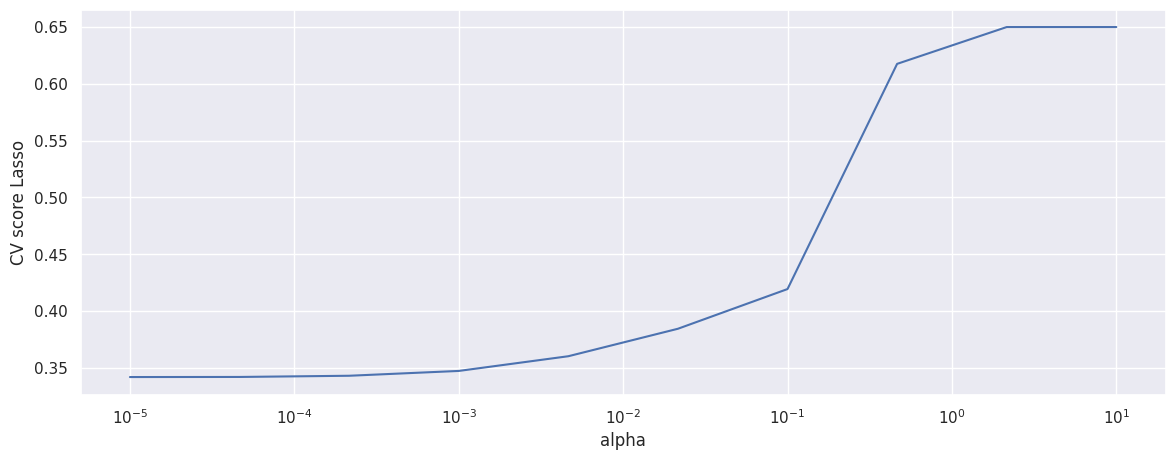

In [ ]:
best_alpha_lasso = searcher_lasso.best_params_["alpha"]
print("Best alpha = %.5f" % best_alpha_lasso)
plt.plot(lasso_alphas, -searcher_lasso.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score Lasso")

Короче, чем меньше альфа, тем лучше

In [ ]:
ridge_alphas = np.logspace(-2, 3, 15)

from sklearn.model_selection import GridSearchCV

searcher_ridge = GridSearchCV(Ridge(), n_jobs=-1, param_grid={"alpha": ridge_alphas}, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', searcher_ridge)
])

model7 = pipeline.fit(X_train, X_train['log_trip_duration'])

best_alpha_ridge = searcher_ridge.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_ridge)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best alpha = 37.2759


Text(0, 0.5, 'CV score Ridge')

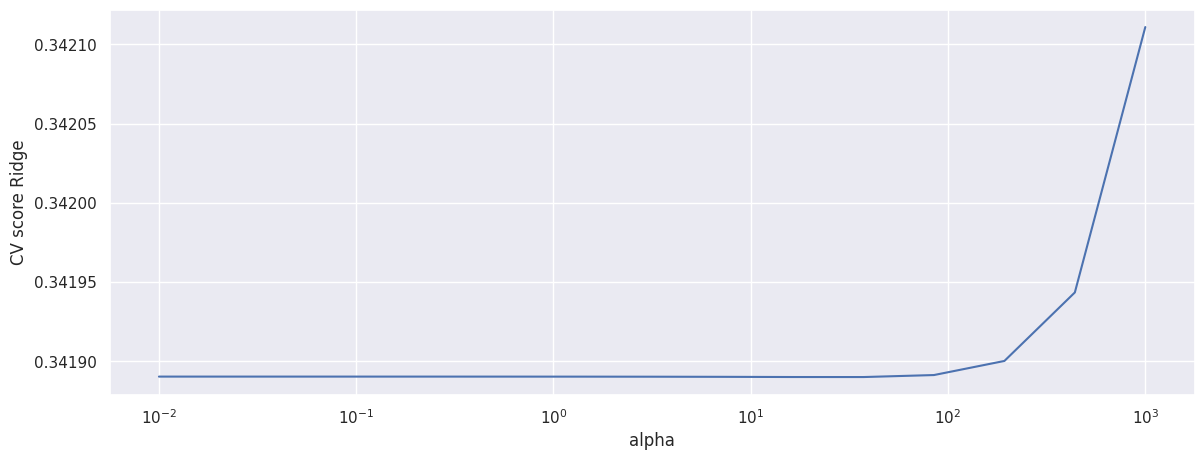

In [ ]:
plt.plot(ridge_alphas, -searcher_ridge.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score Ridge")

In [ ]:
y_pred = model6.predict(X_test)
print("Lasso Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Lasso Test RMSE = 0.4724


In [ ]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])
model9 = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model9.predict(X_test)
print("Ridge Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Ridge Test RMSE = 0.4724


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
zero_weight = []
for alpha in lasso_alphas:
    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha))])
    model = pipeline.fit(X_train, X_train['log_trip_duration'])
    zero_weight.append(np.sum(pipeline.steps[-1][-1].coef_ == 0))

[Text(0.5, 0, 'log of alphas'), Text(0, 0.5, 'number of zero weights')]

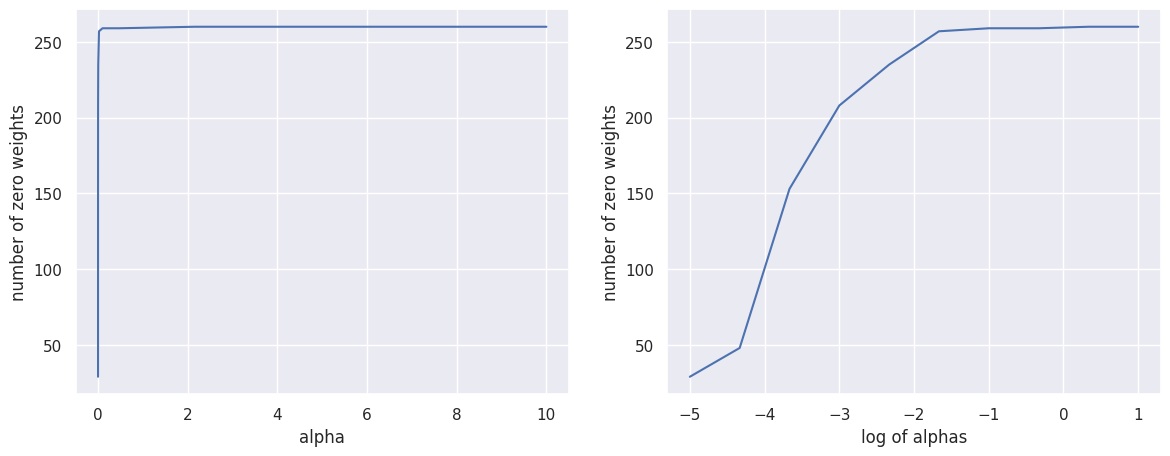

In [ ]:
fig, g = plt.subplots(1,2)
sns.lineplot(x=lasso_alphas, y=zero_weight, ax=g[0])
g[0].set(xlabel='alpha', ylabel='number of zero weights')
sns.lineplot(x=np.log10(lasso_alphas), y=zero_weight, ax=g[1])
g[1].set(xlabel='log of alphas', ylabel='number of zero weights')

In [ ]:
zero_weight

[29, 48, 153, 208, 235, 257, 259, 259, 260, 260]

Чтобы занулить половину весов, надо взять третью альфу

In [ ]:
lasso_alphas[2]

0.00021544346900318823

In [ ]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(lasso_alphas[2]))
])
model10 = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred10 = model10.predict(X_test)
y_pred = model6.predict(X_test)
print("Lasso Test RMSE = %.4f" % mean_squared_error(y_test, y_pred10, squared=False))

Lasso Test RMSE = 0.4741


In [ ]:
print(f'We can lose {mean_squared_error(y_test, y_pred10, squared=False) - mean_squared_error(y_test, y_pred, squared=False)}')

We can lose 0.0017804277038355187


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: так как модель воспринимает каждый признак независимо по отношению к другим, то увидеть такую закономерность она не может

берём код из прошлой домашки

In [40]:
smth = X_train.groupby(['pickup_at_cell', 'dropoff_at_cell']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(100)
smth = smth[['pickup_at_cell','dropoff_at_cell']].values.tolist()
# smth

In [41]:
# X_train2 = X_train.copy()
# X_test2 = X_test.copy()
X_train['path_bw_cell'] = -1
X_test['path_bw_cell'] = -1
for num, from_to in enumerate(smth):
    X_train.loc[(X_train['pickup_at_cell']==from_to[0]) & (X_train['dropoff_at_cell']==from_to[1]), 'path_bw_cell'] = num
    X_test.loc[(X_test['pickup_at_cell']==from_to[0]) & (X_test['dropoff_at_cell']==from_to[1]),'path_bw_cell'] = num

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
X_train.columns

Index(['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'dayofweek', 'month', 'hour',
       'dayofyear', 'is_blizzard', 'is_heat', 'haversine', 'log_haversine',
       'is_jam', 'is_free', 'pickup_lga', 'dropoff_lga', 'pickup_jfk',
       'dropoff_jfk', 'pickup_penst', 'dropoff_penst', 'pickup_gct',
       'dropoff_gct', 'pickup_at_cell', 'dropoff_at_cell',
       'residual_of_regression', 'log_trip_duration', 'is_anomal_wheather',
       'is_lga', 'is_jfk', 'is_penst', 'is_gct', 'path_bw_cell'],
      dtype='object')

In [ ]:
ridge_alphas = np.logspace(0, 5, 15)

categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell', 'path_bw_cell']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

from sklearn.model_selection import GridSearchCV

searcher_ridge = GridSearchCV(Ridge(), n_jobs=-1, param_grid={"alpha": ridge_alphas}, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', searcher_ridge)
])

model666 = pipeline.fit(X_train, X_train['log_trip_duration'])

best_alpha_ridge = searcher_ridge.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_ridge)

In [42]:
# best_alpha_ridge=1
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell', 'path_bw_cell']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])


pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])
model11 = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model11.predict(X_test)
print("Ridge Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Ridge Test RMSE = 0.4630


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

**Ответ**:
* Пусть даны векторы $p, q\in\mathbb{R}^n$, тогда манхэттенским расстояниме назовём $$d_1(p,q)=\sum_{i=1}^n|p_i-q_i|$$
* Название является отсылкой на Манхэттен, ведь там кратчайшее расстояние между двумя точками -- это в точности величина из пункта выше
* Дело в том, что до этого мы использовали haversine distance, что не очень применимо в конкретно нашей задаче, потому что если взглянуть на карту Манхэттана по нужным углом, но несложно увидеть, что он состоит из 12 линий по вертикали(avenue) и $\approx$ 200 линий по горизонтали, перпендикулярных им. Как я написал выше, гораздо правильнее будет считать расстоянием между посадкой и высоткой с помощью данной величины.

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [43]:
new_y = np.array([[40.737361353447774, -73.99689671962783], [40.76434430378565, -73.97719929518735]])
new_x = np.array([[40.759641075512874, -73.9955021011486], [40.75143667747956, -73.9760240731377]])


# location = (X_train['pickup_latitude'].mean(), X_train['pickup_longitude'].mean())
# m = folium.Map(location=location, zoom_start=14)
# folium.PolyLine(new_y,color="red", weight=10).add_to(m)
# folium.PolyLine(new_x,color="red", weight=10).add_to(m)
# show(m)

# 40.75482919993714, -73.98411061929012 -- center

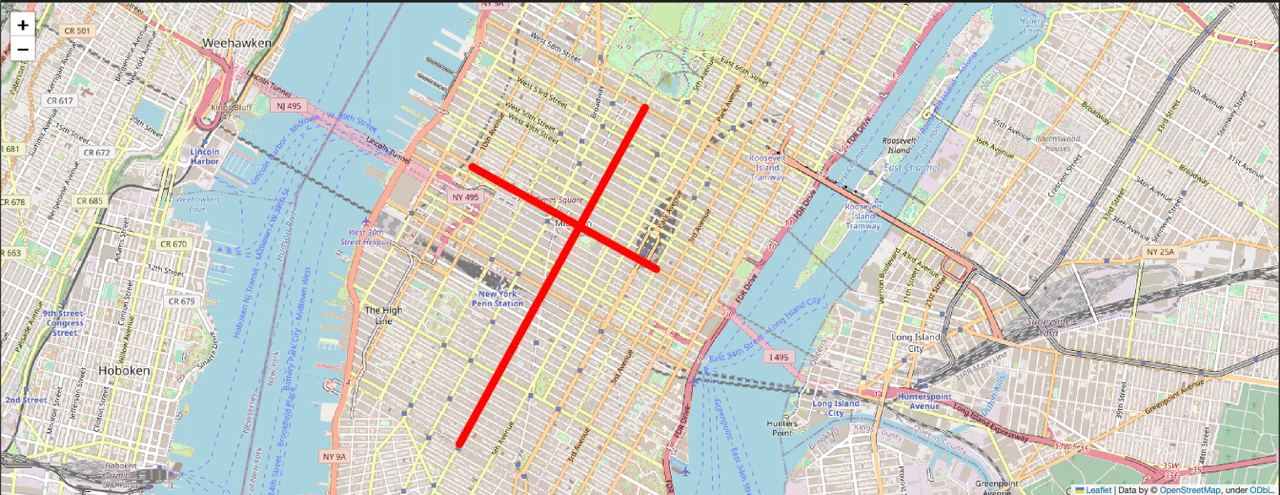

In [44]:
class Manhattan_transform(BaseEstimator, TransformerMixin):
    def __init__(self, line_x, line_y, scale=250):
        self.line_x = line_x
        self.line_y = line_y
        self.scale = scale

    def fit(self, X=None,y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['manhattan_dist'] = self.__manhattan_dist((X['pickup_latitude'], X['pickup_longitude']), (X['dropoff_latitude'], X['dropoff_longitude']))
        X['log_manhattan_dist'] = np.log1p(X['manhattan_dist'])
        return X

    def __manhattan_dist(self, frm, to):
        a = (self.__make('x', frm), self.__make('y', frm))
        b = (self.__make('x', to), self.__make('y', to))
        return np.fabs(a[0] - b[0]) + np.fabs(a[1] - b[1])

    def __vec_prod(self, x, y):
        return x[0]*y[1] - x[1]*y[0]

    def __make(self, type, point):
        if type == 'x':
            vec = (self.line_y[0][0] - point[0], self.line_y[0][1] - point[1])
            return self.scale * (self.__vec_prod(self.line_y[1] - self.line_y[0], vec)/np.linalg.norm(self.line_y[1] - self.line_y[0]))
        elif type == 'y':
            vec = (self.line_x[0][0] - point[0], self.line_x[0][1] - point[1])
            return self.scale * (self.__vec_prod(self.line_x[1] - self.line_x[0], vec)/np.linalg.norm(self.line_x[1] - self.line_x[0]))

Так, мы провели линии, тем самым получили вектора, которые задают нашу плоскость. Осталось найти координаты точек в новой плоскости: для это из каждой точки будем опускать перпендикуляр на прямую и смотреть на его длину, а чиселка, которая получится будет координатой по одной из осей.

In [45]:
mant_trans = Manhattan_transform(new_x, new_y)
X_train = mant_trans.transform(X_train)
X_test = mant_trans.transform(X_test)

<Axes: >

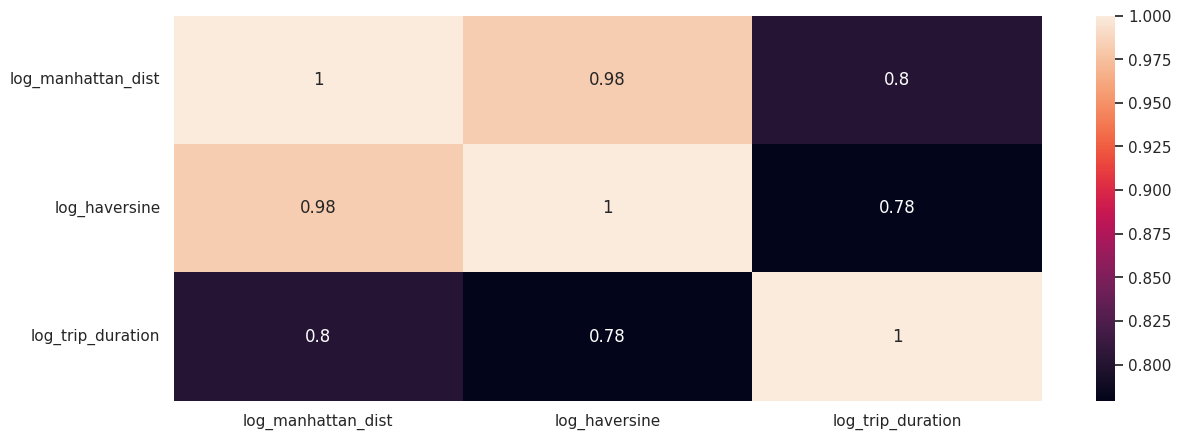

In [ ]:
sns.heatmap(X_train[['log_manhattan_dist','log_haversine', 'log_trip_duration']].corr(), annot=True)

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
ridge_alphas = np.logspace(-2, 5, 15)

categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell', 'path_bw_cell']
numeric_features = ['log_manhattan_dist', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

from sklearn.model_selection import GridSearchCV

searcher_ridge = GridSearchCV(Ridge(), n_jobs=-1, param_grid={"alpha": ridge_alphas}, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', searcher_ridge)
])

model666 = pipeline.fit(X_train, X_train['log_trip_duration'])

best_alpha_ridge = searcher_ridge.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_ridge)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best alpha = 0.0100


In [46]:
# best_alpha_ridge=0.01
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell', 'path_bw_cell']
numeric_features = ['log_manhattan_dist', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])


pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])
model12 = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model12.predict(X_test)
print("Ridge Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Ridge Test RMSE = 0.4396


**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [47]:
!pip install h3
!pip install h3pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h3pandas: filename=h3pandas-0.2.4-py3-none-any.whl size=17657 sha256=1d8c7aa6a98d89b356be5a71f72d22fce0d18088bfcddf13e85318f88c17f3c9
  Stored in directory: /root/.cache/pip/wheels/b7/c1/a1/cfc5bbcd909a037e628ab0bb3717f72f9a2e599f0cfb322520
Successfully built h3pandas


In [48]:
import h3
import h3pandas

Для начала сделаем следующее: для каждой точке на карте создаём шестиугольник разрешениями 10 и 9(первых возьмём 4к, вторых 250), а далее поступаем как в позапрошлой таске(берём уже 200 самых частых направлений, и сопоставляем им номера).

In [52]:
class H3_Transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.all_res_8 = None
        self.all_res_10 = None


    def fit(self, X=None,y=None):
        return self

    def transform(self, X):
        X = X.copy()
        self.pickup_hex_10_res = X[['pickup_longitude', 'pickup_latitude']].h3.geo_to_h3(10, lat_col = 'pickup_latitude', lng_col = 'pickup_longitude').reset_index()['h3_10'].value_counts().head(4000).index.tolist()
        self.dropoff_hex_10_res = X[['dropoff_longitude', 'dropoff_latitude']].h3.geo_to_h3(10, lat_col = 'dropoff_latitude', lng_col = 'dropoff_longitude').reset_index()['h3_10'].value_counts().head(4000).index.tolist()
        self.pickup_hex_09_res = X[['pickup_longitude', 'pickup_latitude']].h3.geo_to_h3(8, lat_col = 'pickup_latitude', lng_col = 'pickup_longitude').reset_index()['h3_08'].value_counts().head(250).index.tolist()
        self.dropoff_hex_09_res = X[['dropoff_longitude', 'dropoff_latitude']].h3.geo_to_h3(8, lat_col = 'dropoff_latitude', lng_col = 'dropoff_longitude').reset_index()['h3_08'].value_counts().head(250).index.tolist()
        X['pickup_hex_10_res'] = X.h3.geo_to_h3(10, lat_col = 'pickup_latitude', lng_col = 'pickup_longitude').index
        X['dropoff_hex_10_res'] = X.h3.geo_to_h3(10, lat_col = 'dropoff_latitude', lng_col = 'dropoff_longitude').index
        X['pickup_hex_08_res'] = X.h3.geo_to_h3(8, lat_col = 'pickup_latitude', lng_col = 'pickup_longitude').index
        X['dropoff_hex_08_res'] = X.h3.geo_to_h3(8, lat_col = 'dropoff_latitude', lng_col = 'dropoff_longitude').index
        X.loc[~X['pickup_hex_10_res'].isin(self.pickup_hex_10_res), 'pickup_hex_10_res'] = ' '
        X.loc[~X['dropoff_hex_10_res'].isin(self.dropoff_hex_10_res), 'dropoff_hex_10_res'] = ' '
        X.loc[~X['pickup_hex_08_res'].isin(self.pickup_hex_09_res), 'pickup_hex_08_res'] = ' '
        X.loc[~X['dropoff_hex_08_res'].isin(self.dropoff_hex_09_res), 'dropoff_hex_08_res'] = ' '
        X['pickup_at_hex_8'] = -1
        X['pickup_at_hex_10'] = -1
        if self.all_res_8 is None:
            self.all_res_8 = X[(X['pickup_hex_08_res'] != ' ') & (X['dropoff_hex_08_res'] != ' ')].groupby(['pickup_hex_08_res', 'dropoff_hex_08_res']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).reset_index(drop=True).head(1000)
        if self.all_res_10 is None:
            self.all_res_10 = X[(X['pickup_hex_10_res'] != ' ') & (X['dropoff_hex_10_res'] != ' ')].groupby(['pickup_hex_10_res', 'dropoff_hex_10_res']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).reset_index(drop=True).head(1000)
        for num, from_to in self.all_res_8.iterrows():
            X.loc[((X['pickup_hex_08_res'] == from_to['pickup_hex_08_res']) & (X['dropoff_hex_08_res'] == from_to['dropoff_hex_08_res'])), 'pickup_at_hex_8'] = num
        for num, from_to in self.all_res_10.iterrows():
            X.loc[((X['pickup_hex_10_res'] == from_to['pickup_hex_10_res']) & (X['dropoff_hex_10_res'] == from_to['dropoff_hex_10_res'])), 'pickup_at_hex_10'] = num
        return X

In [53]:
hex_trans = H3_Transform()
X_train = hex_trans.transform(X_train)
X_test = hex_trans.transform(X_test)

In [54]:
X_train['same_lat_lng'] = 0
X_test['same_lat_lng'] = 0
X_train.loc[(X_train['pickup_longitude'] == X_train['dropoff_longitude']) & (X_train['pickup_latitude'] == X_train['dropoff_latitude']), 'same_lat_lng'] = 1
X_test.loc[(X_test['pickup_longitude'] == X_test['dropoff_longitude']) & (X_test['pickup_latitude'] == X_test['dropoff_latitude']), 'same_lat_lng'] = 1

In [55]:
ridge_alphas = np.logspace(-2, 5, 15)

categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell', 'path_bw_cell', 'pickup_at_hex_8','pickup_at_hex_10', 'pickup_hex_10_res', 'dropoff_hex_10_res', 'pickup_hex_08_res', 'dropoff_hex_08_res']
numeric_features = ['log_manhattan_dist', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

from sklearn.model_selection import GridSearchCV

searcher_ridge = GridSearchCV(Ridge(), n_jobs=-1, param_grid={"alpha": ridge_alphas}, cv=5, scoring="neg_root_mean_squared_error", verbose=3)
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', searcher_ridge)
])

model666 = pipeline.fit(X_train, X_train['log_trip_duration'])

best_alpha_ridge = searcher_ridge.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_ridge)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best alpha = 10.0000


In [61]:
numeric_features = ['log_manhattan_dist', 'log_haversine']
categorical = ['dayofweek', 'month', 'hour', 'dayofyear', 'is_anomal_wheather', 'is_jam', 'is_free', 'is_lga','is_jfk', 'is_penst','is_gct', 'pickup_at_cell', 'dropoff_at_cell', 'path_bw_cell', 'pickup_at_hex_8','pickup_at_hex_10', 'pickup_hex_10_res', 'dropoff_hex_10_res', 'pickup_hex_08_res', 'dropoff_hex_08_res', 'same_lat_lng']


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])
model_last = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model_last.predict(X_test)
print("Ridge Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Ridge Test RMSE = 0.4226


In [62]:
print(0.4396 - 0.4226)

0.017000000000000015


Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

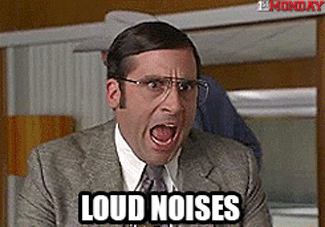